ABR test for orginial data with any sampling or add noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import itertools, operator, random, math
from scipy.sparse.linalg import spsolve_triangular
from sklearn import linear_model
import utils as ut
import pandas as pd
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
def abr(t, pop, popt):
    la, lb, lr, ra, rb, rr = pop
    ka, da, dab = 400, 2, 400
    kb, kbb, db, dba = 2, 30, 2.8, 30
    kr, krb, dr = 0.1, 1.5, 0.2
    at, bt, rt = popt

    dladt = ka*(at-la-ra)*lr - da*la - dab*la*lb**2
    dlbdt = (bt-lb-rb)*(kb + kbb*lb) - db*lb - dba*la*lb**2
    dlrdt = (rt-lr-rr)*(kr+krb*lb) - dr*lr
    dradt = ka*(at-la-ra)*rr - da*ra - dab*ra*rb**2
    drbdt = (bt-lb-rb)*(kb + kbb*rb) - db*rb - dba*ra*rb**2
    drrdt = (rt-lr-rr)*(kr+krb*rb) - dr*rr
    dpop = np.array([dladt, dlbdt, dlrdt, dradt, drbdt, drrdt])
    return dpop

### Test 1 
three different setting - varies both on initial and total molecule number

In [3]:
dt, pts = 0.01, int(60/0.01)
tspan = np.linspace(dt, 60, num=pts)
pop00 = [0.2, 0, 0, 0, 0.8, 1]
pop01 = [0, 0.5, 1, 0.2, 0, 0]
popt1 = [1, 1, 1]

##
sol1 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt1), t_span=[tspan[0], tspan[-1]], y0=pop00, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dpop1 = abr(sol1.t, sol1.y, popt1)
##
sol2 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt1), t_span=[tspan[0], tspan[-1]], y0=pop01, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dpop2 = abr(sol2.t, sol2.y, popt1)


# sol4 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt1), t_span=[tspan[0], tspan[-1]], y0=pop01, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
# dpop4 = abr(sol4.t, sol4.y, popt1)


# sol5 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt1), t_span=[tspan[0], tspan[-1]], y0=pop02, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
# dpop5 = abr(sol5.t, sol5.y, popt1)

# sol6 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt1), t_span=[tspan[0], tspan[-1]], y0=pop03, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
# dpop6 = abr(sol6.t, sol6.y, popt1)





In [4]:
pop_data = np.hstack([sol1.y, sol2.y])
dpop_data = np.hstack([dpop1, dpop2])
dpop_diff = np.hstack([ut.time_different(dt, dpop1, sol1.y), ut.time_different(dt, dpop2, sol2.y)])

In [5]:
 label = ['la', 'lb', 'lr', 'ra', 'rb','rr']
 theta, descr = ut.lib_terms(pop_data,2,label)

In [6]:
clf = linear_model.Lasso(alpha=1e-5, fit_intercept=False, max_iter=1e5)
clf.fit(theta, dpop_diff.T)
Xi_std = clf.coef_

In [7]:
sol_res = integrate.solve_ivp(ut.sparseGalerkin, [tspan[0], tspan[-1]], pop00, method='RK45', atol=1e-10, rtol=1e-10, t_eval=tspan,args=(Xi_std.T,2))

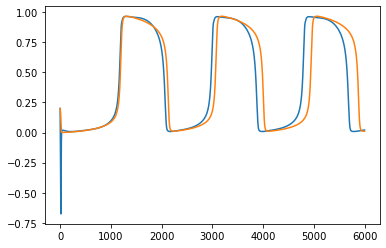

In [11]:
plt.plot(sol_res.y[0])
plt.plot(sol1.y[0])

In [15]:
dic = {}
dic['la'], dic['ra'] = ['rb', 'rr'], ['lb','lr']
dic['lb'], dic['rb'] = ['ra', 'rr'], ['la', 'lr']
dic['lr'], dic['rr'] = ['ra', 'rb'], ['la', 'lb']
df_prior, remain_index = ut.bulid_prior(label, theta, descr, dic)

In [35]:
# important, keep
theta_dic = {}
for i, term in enumerate(label):
    theta_dic[term] = theta[:, remain_index[i]]
    # clf = linear_model.Lasso(alpha=1e-5, fit_intercept=False, max_iter=1e5)
    # clf.fit(theta_dic[term],dpop_diff[i].T)
    # Xi_curr = clf.coef_
    Xi_curr = ut.sparsifyDynamics(theta_dic[term], np.expand_dims(dpop_diff[i].T,1), 0.001)
    df_prior[term].iloc[remain_index[i]] = Xi_curr.T[0]

In [36]:
sol_res2 = integrate.solve_ivp(ut.sparseGalerkin, [tspan[0], tspan[-1]], pop00, method='RK45', atol=1e-10, rtol=1e-10, t_eval=tspan,args=(df_prior,2))

In [42]:
ut.visual_param(Xi_std, descr)

,la,lb,lr,ra,rb,rr
1,46.279969,5.649980,0.000000,15.666974,0.497452,0.000110
rr,-31.589536,5.245584,0.000000,23.255069,0.000000,0.000000
rb,9.261093,-4.198866,0.000000,-6.652560,-2.322399,0.009635
ra,-65.106239,-3.578080,0.011949,-12.214414,0.000000,0.000000
lr,88.159863,-0.575612,0.000000,-25.973087,0.867282,0.000000
lb,-35.208652,-2.009830,0.054939,15.564522,0.000000,0.000000
la,-21.122345,0.908493,0.000000,-30.846350,-0.166418,0.030718
rrrr,55.436022,-2.222112,0.000000,14.782594,0.722018,-0.158621
rbrr,-51.870100,-6.316762,0.000000,74.741780,0.000000,-0.020101
rbrb,-43.337163,0.019681,-0.011475,9.162493,-7.056445,0.000000


In [43]:
df_prior

,la,lb,lr,ra,rb,rr
1,50.313690,15.169055,0.099967,31.833351,7.665716,0.099955
rr,0.000000,0.000000,-0.099961,77.885773,1.011972,-0.299949
rb,0.000000,-35.761182,0.000000,77.714370,-25.205560,1.500162
ra,-344.913797,0.000000,0.000000,-147.882205,5.865806,0.000000
lr,105.193643,-1.594903,-0.299964,0.000000,0.000000,-0.099947
lb,94.859797,-25.370724,1.500122,0.000000,-29.125918,0.000000
la,-187.206197,8.322450,0.000000,-269.944715,0.000000,0.000000
rrrr,0.000000,0.000000,0.000000,6.904794,0.308419,0.000000
rbrr,0.000000,0.000000,0.000000,-69.945140,-1.349986,-1.500182
rbrb,0.000000,20.350323,0.000000,57.791424,17.323041,0.000000
